# Understand Audio Data

In [1]:
import librosa

# importing audio file
file1 = "../data/Balance Memory.wav"
file2 = "../data/Wind Suspense Avant-garde.wav"
file3 = "../data/Lo-Fi Composition.wav"

# using librosa library to output samples data and its sampling rate
samples, sampling_rate = librosa.load(file1, sr=None, mono=True, offset=0.0, duration=None)

# from this data we can infer that if we want a high quality audio such as 48khz, 
# we must to get a higher sampling_rate that will compact more data into a time window that is so called sampling_rate
len(samples), sampling_rate

(480000, 32000)

In [2]:
# if we want to get the audio time, we must divide the samples by sampling_rate, remember that we will get the time in seconds
duration = len(samples) / sampling_rate

duration

15.0

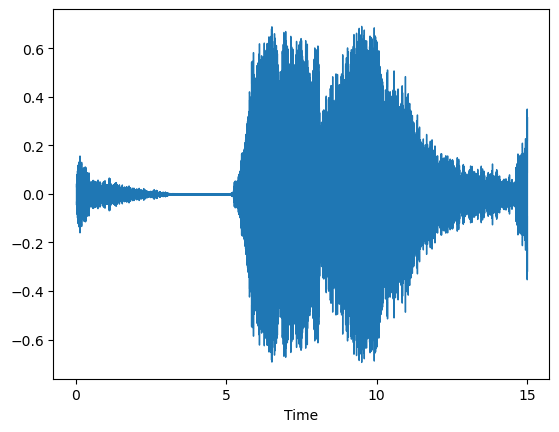

In [3]:
import matplotlib.pyplot as plt

# lets plot audio frequency and amplitude into a graph
librosa.display.waveshow(y=samples, sr=sampling_rate)

In [4]:
import numpy as np
# i want to expand the graph a little bit, because in my opinion its kind of small in axis-x proportion
# and for that we must to construct our matplot graph alone

# the first feature to get done is the time value, from the value above we have the duration, where we can create a time feature based on that
# and also we get take the samples length as time windows like i mentioned before
time = np.linspace(0, duration, len(samples))

time

array([0.00000000e+00, 3.12500651e-05, 6.25001302e-05, ...,
       1.49999375e+01, 1.49999687e+01, 1.50000000e+01])

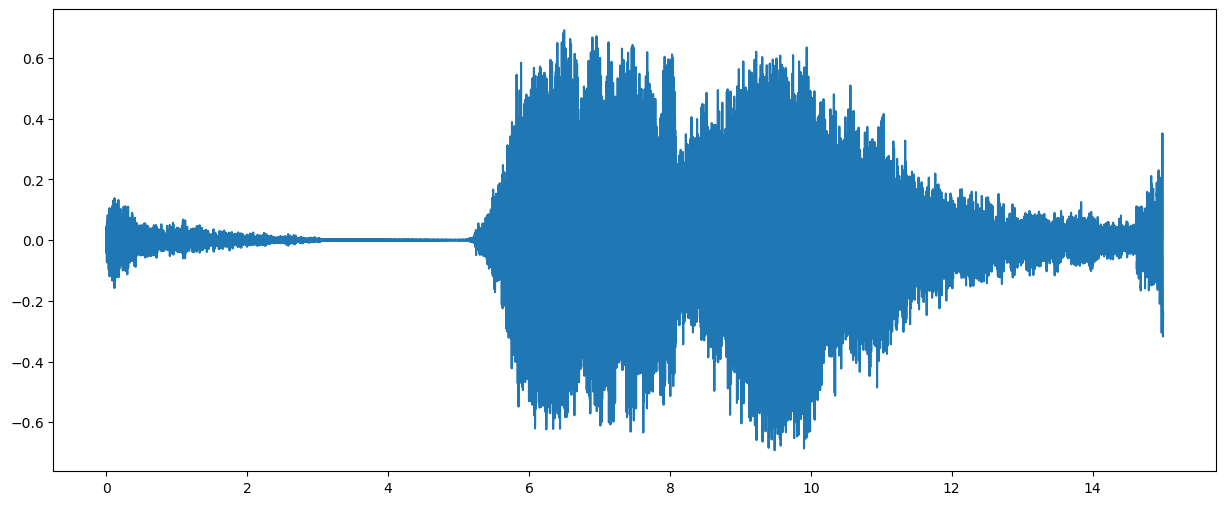

In [5]:
# after getting the time feature, we can plot the stretched graph here to check a more detail waveform :)
plt.figure(figsize=(15, 6))
plt.plot(time, samples)

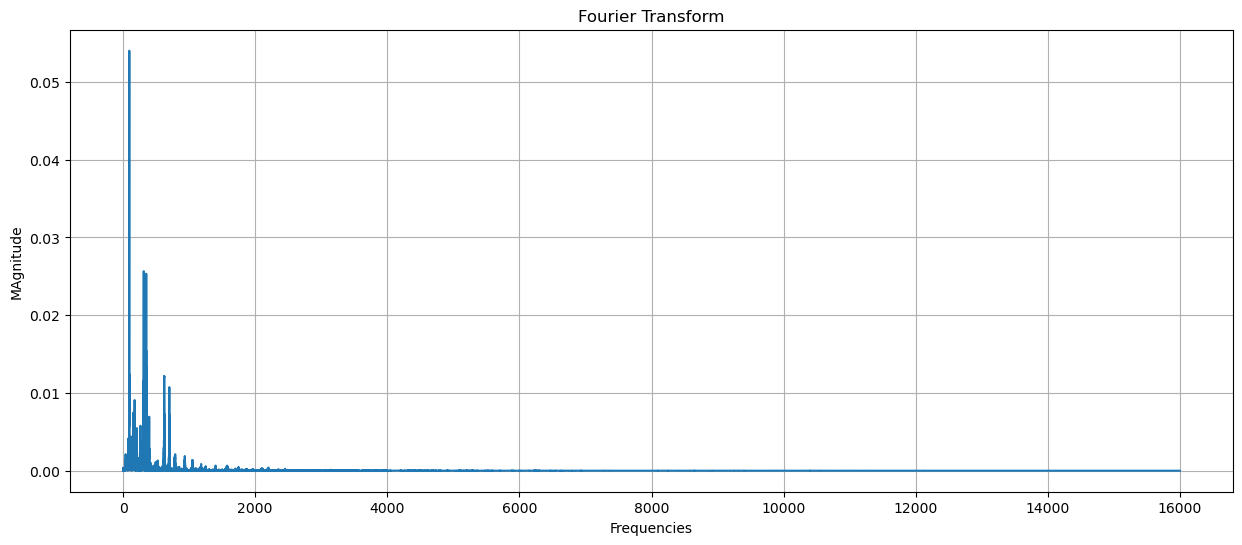

In [6]:
# from the plot above we note that there are so many frequency mixing out with each other, and if we would like to get details of every frequency etc
# we must to apply the FFT technique that got the heatmap, but before that i think is import to know how come before the heatmap, that is where the 
# FOURIER TRANSFORM, which is a teory that categorize the audio each frequency.

from scipy.fft import fft

# samples length
n = len(samples)
# duration of one sample
sample_tempo = 1 / sampling_rate
# nyquist frequency theorem to avoid redundancy
frequency = np.linspace(0.0, 1.0/(2.0*sample_tempo), n//2)
# fast fourier transform with normalization
magnitude = 2.0 / n * np.abs(fft(samples)[:n//2])
# create plot figure
fig, ax = plt.subplots(figsize=(15, 6))
# plotting with values above
ax.plot(frequency, magnitude)
plt.grid()
plt.xlabel("Frequencies")
plt.ylabel("MAgnitude")
plt.title("Fourier Transform")
plt.show()

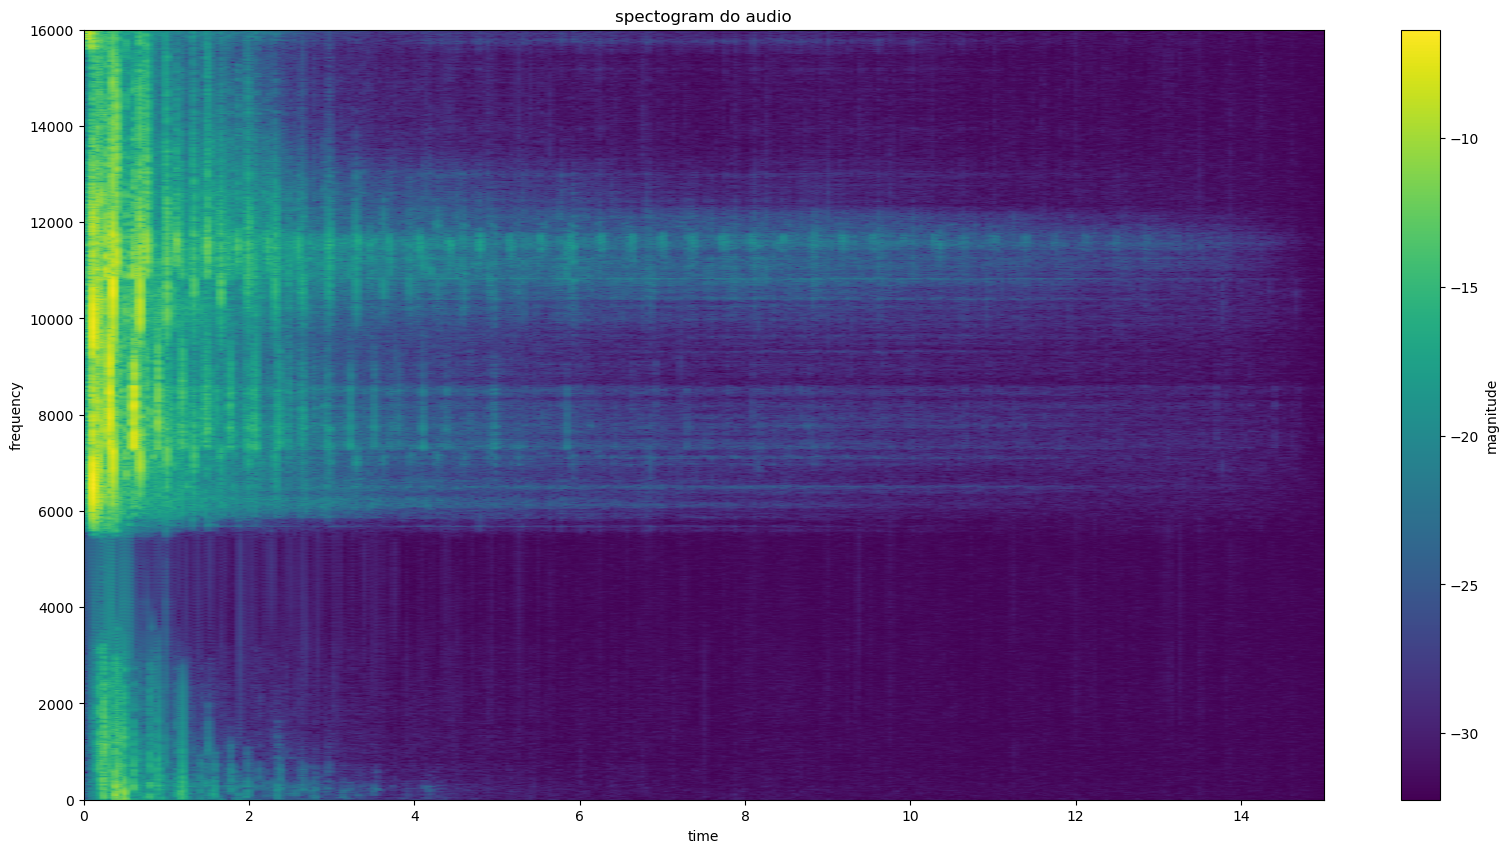

In [7]:
# after analyse the fourier transform graph above, we can see different kind of frequencies but we can find the time series data, where the heatmap
# spectogram enter mentioned above too

# stride size that is overlaying the time windows, generally we will get like stride step half of window size
stride_size = int(0.001 * sampling_rate * 10) # 10ms of stride
window_size = int(0.001 * sampling_rate * 20) # 20ms of window

# extract strided windows, used for the short-time fourier transform
truncate_size = (len(samples) - window_size) % stride_size # number of samples to discard
samples = samples[:len(samples) - truncate_size] # make the signal a multiple stride size
nshape = (window_size, (len(samples) - window_size) // stride_size + 1) # strided windows shape
nstrides = (samples.strides[0], samples.strides[0] * stride_size) # efficient usage
windows = np.lib.stride_tricks.as_strided(samples, shape=nshape, strides=nstrides) # strided windows view

assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)]) # verify correct windowing

# window weighting, to reduce inter-windows leakage
weighting = np.hanning(window_size)[:, None]

# short-time fourier transform and its scale
fft = np.fft.rfft(windows * weighting, axis=0)
fft = np.absolute(fft)
fft = fft**2

# normalize stft scale
scale = np.sum(weighting**2) * sampling_rate
fft[1:-1,:] *= (2 / scale)
fft[(0, -1), :] /= scale

# compute frequency of specgram
freqs = float(sampling_rate) / window_size * np.arange(fft.shape[0])

# specgram (log-magnitude representation)
ind = np.where(freqs <= sampling_rate/2)[0][-1] + 1
specgram = np.log(fft[:ind, :] + 1e-14)

plt.figure(figsize=(20, 10))

plt.imshow(
    specgram.T,
    origin="lower",
    aspect="auto",
    extent=[0, len(samples)/sampling_rate, 0, sampling_rate / 2],
    cmap="viridis"
)

plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(label="magnitude")
plt.title("spectogram do audio")
plt.show()

In [9]:
specgram, specgram.shape

(array([[-20.38397437, -22.19611559, -25.04075957, ..., -11.5461785 ,
          -8.49102216,  -7.84055039],
        [-20.48582222, -21.75004303, -21.18793824, ...,  -9.55422233,
          -7.61115947,  -7.21893612],
        [-19.57864716, -20.60574643, -20.58610137, ..., -13.3182021 ,
          -8.67261678,  -8.59449088],
        ...,
        [-31.7999891 , -32.15662449, -32.02445449, ..., -32.11455063,
         -31.80803122, -31.36509604],
        [-32.02180039, -32.07629802, -32.04717418, ..., -32.11645017,
         -31.76058705, -32.12533221],
        [-32.1491188 , -32.16024583, -32.03725964, ..., -31.87601272,
         -32.22503803, -31.93460278]]),
 (321, 1499))